In [1]:
#尝试增加描述符（全套）

import numpy as np
import random
import molvecgen

import rdkit
from rdkit import Chem, DataStructs, rdBase
from rdkit.Chem import rdFMCS, AllChem, RDKFingerprint, Descriptors, rdMolDescriptors, AllChem, QED
from rdkit import DataStructs
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer
mol = Chem.MolFromSmiles('NC(=O)c1ccccc1')
s = sascorer.calculateScore(mol)

import h5py
import pandas as pd
import ast
import pickle
from ipywidgets import interact

from ddc_pub import ddc_v3 as ddc

# 计算子结构相似度
def get_sim(mol, sub_mol) -> float: 
    try:
        res = rdFMCS.FindMCS([mol, sub_mol], timeout=1, bondCompare=rdFMCS.BondCompare.CompareAny, ringMatchesRingOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)
        if res.smartsString == "" or res.canceled:
            return 0
        mcs_mol = Chem.MolFromSmarts(res.smartsString)
        Chem.SanitizeMol(mcs_mol)

        mcs_mol_fp = RDKFingerprint(mcs_mol)
        sub_mol_fp = RDKFingerprint(sub_mol)
        sim = DataStructs.FingerprintSimilarity(sub_mol_fp, mcs_mol_fp)

        return sim
    except Exception as e:
        #print(e)
        return 0

# 计算描述符
def get_descriptors(mol, sub_mol) -> list:
    descriptors = []
    if mol:
        try:
            logp = Descriptors.MolLogP(mol)
            tpsa = Descriptors.TPSA(mol)
            sim = get_sim(mol, sub_mol)
            hba = rdMolDescriptors.CalcNumHBA(mol)
            hbd = rdMolDescriptors.CalcNumHBD(mol)
            qed = QED.qed(mol)
            sas = sascorer.calculateScore(mol)

            descriptors = [logp, tpsa, sim, qed, hba, hbd, sas]
        except Exception as e:
            #print(e)
            return descriptors
    else:
        print("Invalid generation.")
    return descriptors

# 生成器
class mol_generator:
    def __init__(self, seed_smile:str = "", sub_smile:str = "", model = None, target_names:list = [], qsar_model:str = ""):
        self.mols = []
        self.target = []
        self.target_names = target_names
        self.sani_mols = []
        self.sani_properties = []
        self.data = None
        self.set_seed(seed_smile)
        self.set_sub(sub_smile)
        self.set_model(model)
        self.set_qsar_model(qsar_model)

    def set_seed(self, seed_smile):
        if seed_smile == "":
            return
        #self.seed_smile = seed_smile
        self.seed_mol = Chem.MolFromSmiles(seed_smile)

        print("Seed Molecular:")
        print(Chem.MolToSmiles(self.seed_mol))

    def set_sub(self, sub_smile):
        if sub_smile == "":
            return
        self.sub_mol = Chem.MolFromSmiles(sub_smile)

        print("Substruct:")
        print(Chem.MolToSmiles(self.sub_mol))

    def set_model(self, model):
        if model == "":
            return

        #根据model参数的类型，从文件载入模型或直接接收trainer的模型
        if type(model)==str:
            self.model = ddc.DDC(model_name=model)
        else:
            self.model = model

    def set_qsar_model(self, qsar_model):
        if(qsar_model == ""):
            return
        self.qsar_model = pickle.load(open(qsar_model, "rb"))["classifier_sv"]

    # 检查分子
    def sanitize(self, mol):  
        try:
            Chem.SanitizeMol(mol)
            return mol
        except Exception as e:
            return None
            #print(e)

    # 采样指定性质的分子
    def sample(self, sample_times: int = 4, conditions: list = [None]*6):
        # 确定目标
        #assert len(conditions) >= 7
        self.target = get_descriptors(self.seed_mol, self.sub_mol)
        for i in range(len(conditions)):
            if(conditions[i] != None):
                self.target[i] = conditions[i]
        self.target = np.array(self.target)
        print("Sampling with target:{:}.".format(self.target))
        # 采样
        smiles_out = []
        self.model.batch_input_length = 256  # 太大会减慢速度
        for i in range(sample_times):
            smiles, _ = self.model.predict_batch(latent=self.target.reshape(1, -1), temp=1.0)
            #print("#{:}:{:}".format(i,smiles))
            smiles_out.append(smiles)
        smiles_out = np.concatenate(smiles_out)
        self.mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]
        # 检查分子
        self.sani_mols.clear()
        self.sani_properties.clear()
        for mol in self.mols:
            sani_mol = self.sanitize(mol)
            if sani_mol != None:
                self.sani_mols.append(sani_mol)
                self.sani_properties.append(get_descriptors(sani_mol, self.sub_mol))
        # 打印结果
        print("生成分子数:{:},有效性:{:}".format(
            len(self.mols), len(self.sani_mols)/len(self.mols)))

    # 根据id显示生成的分子
    def showmol(self, i):  
        display(Chem.MolToSmiles(self.sani_mols[i]))
        display(Chem.Draw.MolToImage(self.sani_mols[i]))

    # 筛选sub_similarity==1的分子
    def filter_data(self, filename: str=""):
        #筛选结果
        #print("Saving results.")
        self.binmols = np.asarray([[i.ToBinary() for i in self.sani_mols]])
        self.binmols_data = pd.DataFrame(self.binmols.T, columns=["binmol"], copy=True)
        self.properties_data = pd.DataFrame(self.sani_properties, columns=self.target_names, copy=True)
        self.filtered_data = self.binmols_data.loc[[i==1 for i in self.properties_data["sub_similarity"]]]
        print("Filtered {} mols.".format(len(self.filtered_data["binmol"])))
        #保存文件
        with h5py.File(filename, "w") as f:
            f.create_dataset("mols", data=np.asarray(self.filtered_data["binmol"]))
    
    # 导出数据
    def dump(self, mols_filename:str = "", properties_filename:str=""):
        with open(mols_filename, "wb") as f:
            pickle.dump(self.sani_mols, f)
        with open(properties_filename, "wb") as f:
            pickle.dump(self.sani_properties, f)
    
    def load_data(self, mols_filename:str = "", properties_filename:str=""):
        with open(mols_filename, "rb") as f:
            self.sani_mols = pickle.load(f)
        with open(properties_filename, "rb") as f:
            self.sani_properties = pickle.load(f)
    
    def show_data(self, n=5):  # 以表格形式显示生成的分子的属性
        self.data = pd.DataFrame(self.sani_properties,
                                 columns=self.target_names, copy=True)
        display(self.data.head(n))

    def plot(self):  # 绘制样品分布
        try:
            target_dict = {t[0]: t[1] for t in zip(self.target_names, self.target)}
            axes = self.data.hist(bins=25, figsize=(8, 6))
            for i, ax in enumerate(axes.flatten()):
                title = ax.title.__dict__["_text"]
                if title:
                    ax.axvline(x=target_dict[title], color='r', linestyle='dashed', linewidth=2)
        except Exception:
            pass

    def interact(self):  # 显示下拉菜单
        _ = interact(self.showmol, i=range(len(self.sani_mols)))

In [ ]:
target_names = ["logp", "tpsa", "sub_similarity", "qed", "hba", "hbd", "sa_score"]      
sub_smiles = "O=C(OC)C1=CC(C2=O)CCCC2C1=O"
seed_smiles = "CC1(C)C(CCC2(C)C1CCC(C34C)(C)C2CC(C)(C4=O)C(C)=C(C(OC)=O)C3=O)=O"

generator = mol_generator(target_names=target_names, seed_smile=seed_smiles, sub_smile=sub_smiles, model="models/model_0824_final")


In [5]:
generator.load_data("datasets/generator_0823_m.pickle", "datasets/generator_0823_p.pickle")
generator.show_data()

,logp,tpsa,sub_similarity,qed,hba,hbd,sa_score
0,3.5446,97.74,0.185328,0.523915,6,1,4.952144
1,5.7606,69.67,0.077220,0.297893,5,0,5.767544
2,5.9886,80.67,0.098456,0.368431,5,1,6.129787
3,4.6101,83.83,0.100386,0.603569,5,2,7.080544
4,6.0230,69.67,0.619691,0.446232,5,0,5.920988


In [15]:
#generator.sample(4, [None]*6+[7.5])
generator.sample()
generator.show_data()

Sampling with target:[ 4.4719     77.51        1.          0.34974601  5.          0.
  5.42385521].
生成分子数:1024,有效性:0.9560546875


,logp,tpsa,sub_similarity,qed,hba,hbd,sa_score
0,4.2479,77.51,0.434363,0.291809,5,0,6.301971
1,4.4719,77.51,0.816602,0.349746,5,0,5.017508
2,4.4939,77.51,0.314672,0.286349,5,0,5.614801
3,4.4746,77.51,0.816602,0.386496,5,0,6.040127
4,4.4719,77.51,0.741313,0.383763,5,0,5.520536


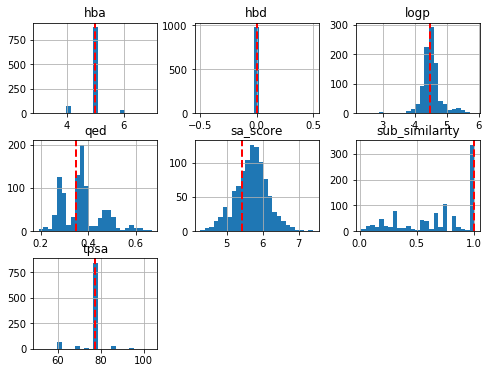

In [16]:
generator.plot()

In [17]:
display(generator.data.sort_values("sub_similarity").tail(5))

,logp,tpsa,sub_similarity,qed,hba,hbd,sa_score
790,4.4719,77.51,1.0,0.376436,5,0,6.484691
792,4.3278,77.51,1.0,0.370032,5,0,6.804307
89,4.2479,77.51,1.0,0.297442,5,0,5.949596
497,4.3920,77.51,1.0,0.289771,5,0,5.901407
978,4.4719,77.51,1.0,0.385257,5,0,5.745328


'COC(=O)C1=C2CC(C)(C)CC(C)(C)C23C(=O)C(C)(CCC3C(C)(C)C(C)=O)C1=O'

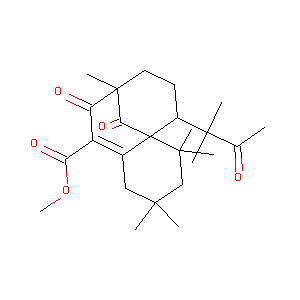

In [21]:
generator.showmol(978)

In [ ]:
generator.interact()